In [24]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import seaborn as sns
import shap
import optuna
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [2]:
tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("data/tr_types.csv", sep=";", index_col="tr_type")
transactions = pd.read_csv("data/transactions.csv", index_col="customer_id")
gender = pd.read_csv("data/gender.csv", index_col="customer_id")
gender = gender[gender['gender'].notna()]

In [3]:
# колонку даты и времени преобразуем к корректному формату
transactions['tr_datetime'] = transactions["tr_datetime"].apply(lambda x: 
                                                                datetime.datetime.combine(datetime.date(2020, 1, 1) + 
                                                                                                    datetime.timedelta(days= int(x.split()[0])), 
                                                                                                    datetime.time(hour= int(x.split()[1].split(':')[0]), 
                                                                                                                  minute= int(x.split(':')[0:2][1]))))

In [4]:
# соединяем транзакции и пол 
transactions = transactions.join(gender)
transactions = transactions.sort_values(by= 'tr_datetime')
x_train = transactions[transactions['gender'].isna()]
transactions = transactions.dropna(subset=['gender'])

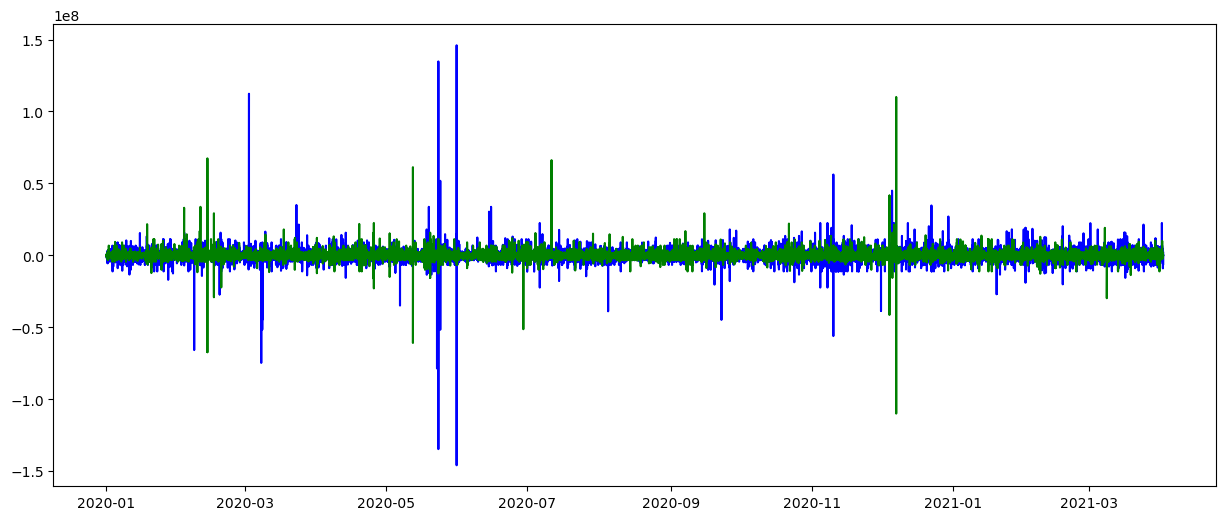

In [5]:
# график amount разных полов
plt.figure(figsize=(15, 6))
plt.plot(transactions['tr_datetime'][gender['gender'] == 1], transactions['amount'][gender['gender'] == 1], color = 'blue')
plt.plot(transactions['tr_datetime'][gender['gender'] == 0], transactions['amount'][gender['gender'] == 0], color = 'green');

Предполагаем, что 1 - мужчины, 0 - женщины. 

Проверим!

In [6]:
# временной охват данных
transactions['tr_datetime'].max() - transactions['tr_datetime'].min()

Timedelta('456 days 23:59:00')

In [7]:
# Маркер покупки 1 - покупка, 0 - пополнение
transactions['purchase'] = [1 if i < 0 else 0 for i in transactions['amount']] 

In [8]:
# ФУНКЦИИ FEATURES ENGINEERING

# amount заданных функций по отрезкам времени
# применяется к transactions
def calculate_amount(data: pd.DataFrame, func: list):
    # пустой датафрейм
    dtfrm = pd.DataFrame()
    # Итерируемся по списку функций и добавляем столбцы в датафрейм
    for i in func:
        # Series, состоящие из amount функций по отрезкам времени
        dtfrm['{}_hour_amount'.format(i)] = data.groupby([data.index, data['tr_datetime'].dt.hour])['amount'].transform(i).round(1)
        dtfrm['{}_day_amount'.format(i)] = data.groupby([data.index, data['tr_datetime'].dt.day])['amount'].transform(i).round(1)
        dtfrm['{}_weekday_amount'.format(i)] = data.groupby([data.index, data['tr_datetime'].dt.weekday])['amount'].transform(i).round(1)
        dtfrm['{}_month_amount'.format(i)] = data.groupby([data.index, data['tr_datetime'].dt.month])['amount'].transform(i).round(1)
        dtfrm['{}_quarter_amount'.format(i)] = data.groupby([data.index, data['tr_datetime'].dt.quarter])['amount'].transform(i).round(1)
    # на выходе датасет с индексацией и размером как transactions
    return dtfrm 



# amount пользователей по колонке (по заданным функциям)
# применяется к transactions
def calc_mean_amount_column_by_customer_id(data, column: str, func: list):
    dtfrm = pd.DataFrame()
    for i in func:
        dtfrm[f'{i}_amount_{column}_by_customer_id'] = data.groupby(['customer_id', column])['amount'].transform(i)
    # на выходе датасет с индексацией и размером как transactions
    return dtfrm



# amount пользователя по заданным колонкам и функциям
def calc_func_data(data, column: str, functions: list):
    # создаем датафрейм для дальнейшего заполнения 
    data_frame = pd.DataFrame()
    # итерируемся по функциям
    for function in functions:
        # вычисляем значение функции по категориям колонки 
        data_func = pd.crosstab(
            data.index,
            data[column],
            values= data['amount'],
            aggfunc= function
            ).fillna(0)
        # костыль для пригодного формата датафрейма и правильного переименования колонок
        data_func_customers = pd.DataFrame()
        for i in data_func.columns:
            data_func_customers[f'{function}_{column}_{i}'] = data_func[i]
        # объединяем данные с разными функциями в единый датафрейм
        data_frame = pd.concat([data_frame, data_func_customers], axis= 1)
        data_frame.index.rename('customer_id', inplace=True)

    return data_frame

In [9]:
# объединяем в датасет все новые фичи
X = pd.concat(
    [
        transactions, 
        calc_mean_amount_column_by_customer_id(transactions, 'mcc_code', ['mean', 'max', 'min', 'sum', 'count']),
        calculate_amount(transactions, ['mean', 'min', 'max', 'sum'])], 
        axis= 1
        )

customers = X[
    X.columns.to_list()[5:]
    ].groupby(['customer_id']).mean()

df = pd.concat(
    [
        customers, 
        calc_func_data(transactions, 'mcc_code', ['min', 'max', 'mean', 'count']), 
        calc_func_data(transactions, 'tr_type', ['min', 'max', 'mean'])
        ], 
        axis= 1
        )

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

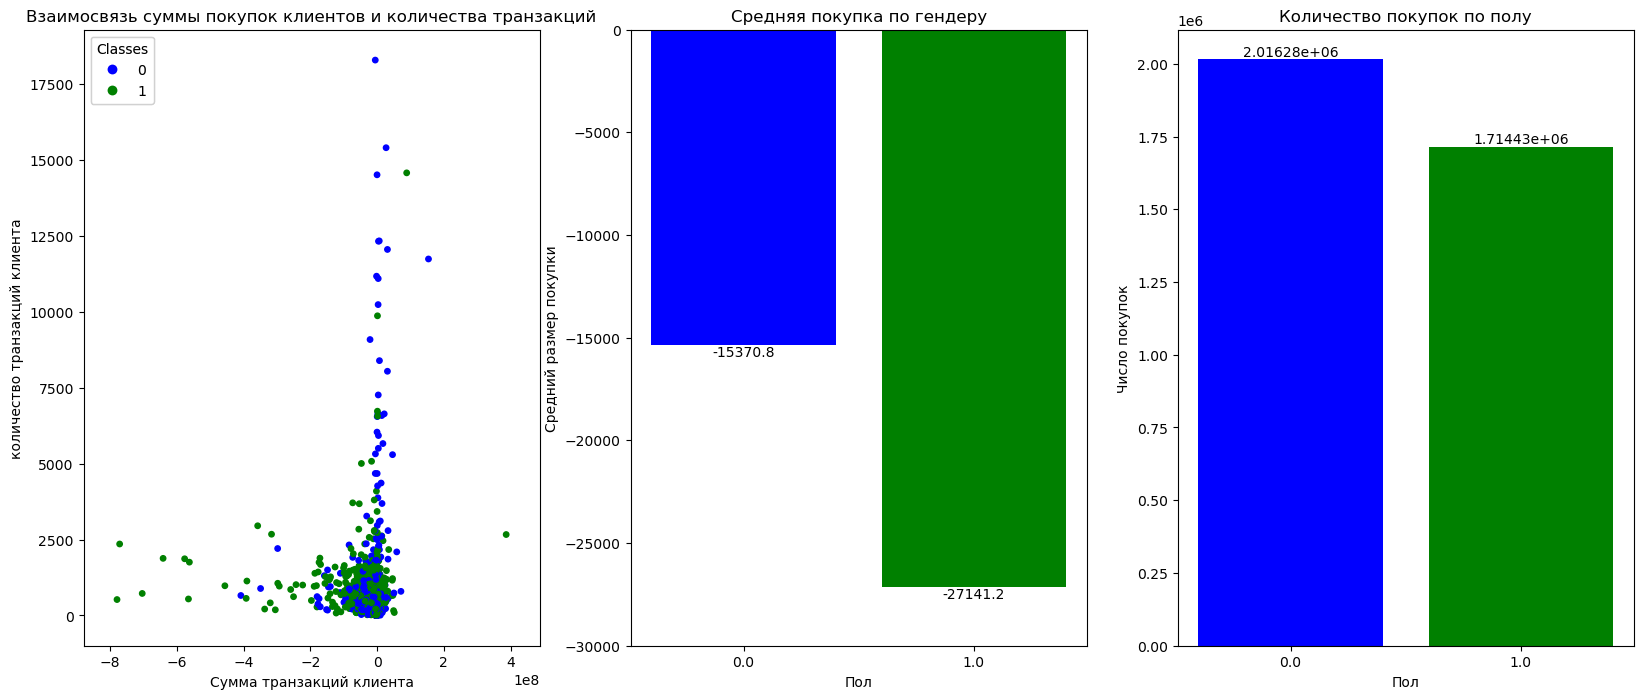

In [91]:
# Средний размер покупок по полу 
# fig, ax = plt.subplots(1, 2, figsize = (20, 8))
fig, ax = plt.subplots(nrows= 1 , ncols= 3, figsize = (20, 8))

# левый график
x_min_lim = transactions.groupby([transactions.index])['amount'].sum().min() - 10 ** 8
x_max_lim = transactions.groupby([transactions.index])['amount'].sum().max() + 10 ** 8
y_min_lim = transactions.groupby([transactions.index])['amount'].count().min() - 10 ** 3
y_max_lim = transactions.groupby([transactions.index])['amount'].count().max() + 10 ** 3
ax[0].set_title('Взаимосвязь суммы покупок клиентов и количества транзакций')
scatter = ax[0].scatter(
       transactions.groupby([transactions.index])['amount'].sum(), 
       transactions.groupby([transactions.index])['amount'].count(), 
       c= df['gender'],
       cmap= mcolors.ListedColormap(['blue', 'green']),
       s= 15
       )
ax[0].set_xlabel("Сумма транзакций клиента")
ax[0].set_ylabel("количество транзакций клиента")
ax[0].set(
       xlim=(x_min_lim, x_max_lim),
       ylim=(y_min_lim, y_max_lim)
       )
legend = ax[0].legend(
       *scatter.legend_elements(),
       loc="upper left", title= "Classes"
                    )
ax[0].add_artist(legend)



# средний график
bar_container = ax[1].bar(
    transactions.groupby([transactions.gender])['amount'].mean().index.map(str),
    transactions.groupby([transactions.gender])['amount'].mean().values,
    color= ['blue', 'green']
    )
ax[1].set(ylabel= 'Средний размер покупки',
          xlabel= 'Пол',
       title='Средняя покупка по гендеру', 
       ylim=(-30000, 0)
       )
ax[1].bar_label(bar_container)


# правый график
bar_container = ax[2].bar(
    transactions.groupby([transactions.gender])['amount'].count().index.map(str),
    transactions.groupby([transactions.gender])['amount'].count().values,
    color= ['blue', 'green']
    )
ax[2].set(ylabel= 'Число покупок',
          xlabel= 'Пол',
       title='Количество покупок по полу'
       )
ax[2].bar_label(bar_container)
plt.show();

In [10]:
# формируем датасет для обучения
Y = df['gender']
df_train = df.drop(['gender'], axis= 1).fillna(0)
x_train, x_valid, y_train, y_valid = train_test_split(df_train, Y, random_state= 900, test_size = 0.2)

In [11]:
# обучаемся на всех имеющихся данных c ручным подбором параметров для модели

cat_clf = CatBoostClassifier(iterations= 540, learning_rate= 0.029, depth= 2, random_seed= 0, verbose= False)

cat_clf.fit(x_train, y_train)

print("Train ROC-AUC score:", roc_auc_score(cat_clf.predict(x_train), y_train))
print("Valid ROC-AUC score:", roc_auc_score(cat_clf.predict(x_valid), y_valid))

Train ROC-AUC score: 0.7986744614730883
Valid ROC-AUC score: 0.7890560417054552


In [ ]:
# отбор признаков SHAP
explainer = shap.Explainer(cat_clf)
# explainer = shap.Explainer(cat_clf)
shap_values = explainer.shap_values(x_train)

# shap_values = explainer(x_train)

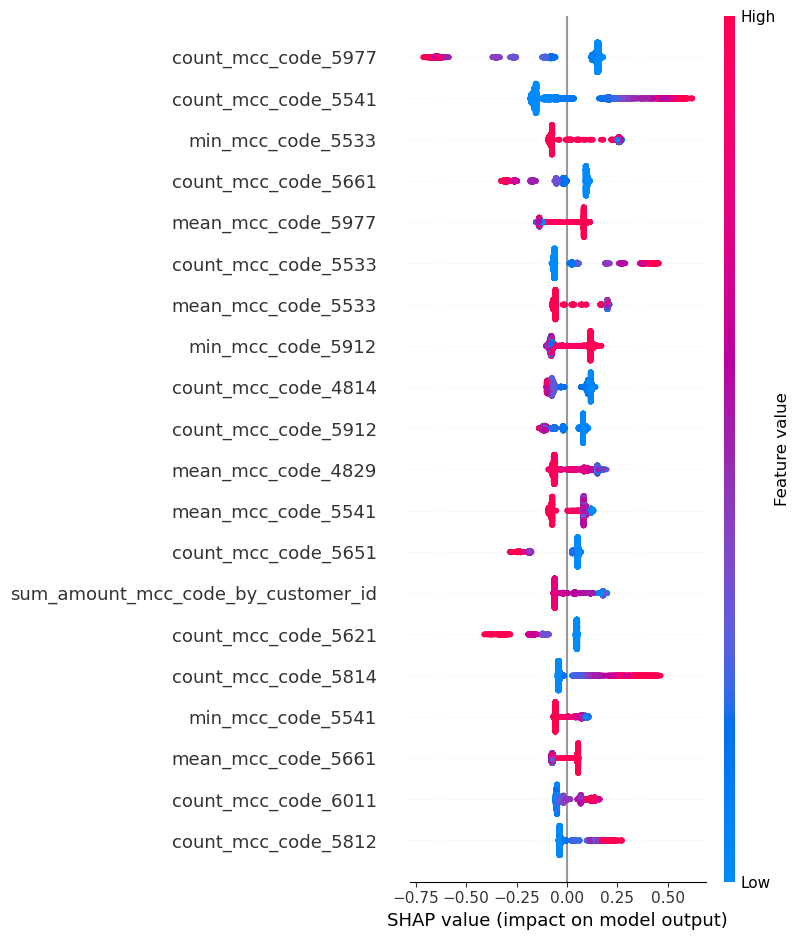

In [ ]:
# shap.plots.bar(shap_values)
shap.summary_plot(shap_values, x_train)

Таким образом, можно смело подтвердить ранее выдвинутую гипотезу: 0 - это женщины, 1 - это мужчины.

Самыми характерными категориями для мужчин оказались:
* 5541 - Заправочные станции 
* 5921 - Магазины, которые продают спиртные напитки на вынос
* 4814 - Телекоммуникационные услуги
* 5251 - Скобяные товары в розницу
* 5732 - Продажа электронного оборудования

Самые характерные категории для женщин:
* 5977 - Магазины косметики
* 5661 - Обувные магазины
* 5651 - Одежда для всей семьи
* 5912 - Аптеки
* 5651 - Магазин мужской и женской одежды

In [ ]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([x_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
693,count_mcc_code_5977,0.212561
642,count_mcc_code_5541,0.195264
89,min_mcc_code_5533,0.119203
652,count_mcc_code_5661,0.109449
509,mean_mcc_code_5977,0.102353
...,...,...
375,max_mcc_code_8011,0.0
376,max_mcc_code_8021,0.0
377,max_mcc_code_8043,0.0
378,max_mcc_code_8062,0.0


In [ ]:
# обучаемся на фичах отобраных при помощи коэффициента Шепли
x_train, x_valid, y_train, y_valid = train_test_split(df_train[importance_df['column_name'].head(300).values], Y, random_state= 900, test_size = 0.2)

cat_clf1 = CatBoostClassifier(iterations= 600, learning_rate= 0.028, depth= 2, random_seed= 0, verbose= False)

cat_clf1.fit(x_train, y_train)

print("Train ROC-AUC score:", roc_auc_score(cat_clf1.predict(x_train), y_train))
print("Valid ROC-AUC score:", roc_auc_score(cat_clf1.predict(x_valid), y_valid))

Train ROC-AUC score: 0.7997016017560128
Valid ROC-AUC score: 0.7991978609625668


In [ ]:
# OPTUNA
def objective(trial):
    X= df_customers.fillna(0)
    y= Y
    categorical_features_indices = np.where(X.dtypes != np.float)[0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
        'iterations': trial.suggest_int('iterations', 200, 2000),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.1),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)
    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    roc_auc = roc_auc_score(y_test, pred_labels)
    return roc_auc


if __name__ == "__main__":
    study = optuna.create_study(direction= "maximize")
    study.optimize(objective, n_trials= 50, timeout= 600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("Value: {}".format(trial.value))

    print("Params: ")
    for key, value in trial.params.items():
        print("{}: {}".format(key, value))

[I 2023-07-22 19:55:08,273] A new study created in memory with name: no-name-c61fc7e4-dcdd-47a2-8d84-e6a34791df1e
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2023-07-22 19:55:08,938] Trial 0 finished with value: 1.0 and parameters: {'iterations': 704, 'learning_rate': 0.03101498561276919, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.05701448089203794, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.7362352987441163}. Best is trial 0 with value: 1.0.
`np.float

Number of finished trials: 50
Best trial:
  Value: 1.0
  Params: 
    iterations: 704
    learning_rate: 0.03101498561276919
    objective: CrossEntropy
    colsample_bylevel: 0.05701448089203794
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 3.7362352987441163


In [ ]:
# optuna.visualization.plot_param_importances(study)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)